## 실제 사용 함수
- 데이터 베이스 연결
- 인풋 받아오는 함수
- 아웃풋 까지

### 구상 지표 만들기
- 필요 정보
날짜별 - 시세, 감정지수()

- 추천기준이되는 정보

개인의 투자 기간 n = 예)1주/1달/3달/6달  <--- 주식과 달리 7일,   n= 7,30,90,180

주기는 2*n 로 평균이동선 측정. 왜냐면 저점에서 고점에 판다라고 생각(주기의 반)  그누구도 고점에사서 고점에 팔지 않기 때문

함수가 필요한 평균이동선 = 2*n

**감정지수 마찬가지

- 결국 이동평균선에 따라 z밸류를 각각 구하고 그 평균을 저장


### 구상-지표로 분류 순번 지정
z밸류를 제곱하여 기간에 의해 평균을 낸다. 

- 어느범위의 값들을 제곱루트평균낼지 지정 
- 이 값들을 새로운 하나의 테이블로 구성시킨다.
- 순위를 부여한다.

### 구상-순번 지정값에 의거해서 추천 로직, 아웃풋 까지

- 순위에따라 가상의 순서를 부여받은 것을 추천로직의 인풋에따라 함수를 지나 점수를 받는다.
- 함수는 우상,중앙 볼록한,우하
- 최종적으로 최고의 점수를 갖는 암호화패(주식을) 분류 할수 있다.
- 그리고 그 것을 아웃풋한다.

### 추천 로직 - 함수
-함수는 위로 뽀족한 절대값 함수
-고객이 원하는 지점이 가장 높게 만든다 인풋에 의해 변할 수 있게

## I. 패키지 밎 자료 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install pymysql

     |████████████████████████████████| 43 kB 1.5 MB/s 


In [6]:
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import operator

import base64
from io import BytesIO

from datetime import datetime, timedelta

### 1)데이터베이스 커리해서 가져오기

- globals() 사용

In [54]:
crypto_name = ['ADA','BTC','BTC','DOGE','EOS','ETH','OMG','SNT','XRP']

for i in crypto_name:
  db = pymysql.connect(host='35.76.154.105', port=3306, user='root', passwd='1234',db='upbit', charset='utf8')
  cursor = db.cursor(pymysql.cursors.DictCursor)
  sql = 'SELECT * FROM {0}'.format(i)
  cursor.execute(sql)
  result = cursor.fetchall()
  globals()[f'{i}'] = pd.DataFrame(result)

In [55]:
BTC

,index,open,high,low,close,volume,value
0,2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
1,2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2,2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
3,2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
4,2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...,...
1511,2021-11-14 09:00:00,77867000.0,79350000.0,77579000.0,79310000.0,3826.416588,3.001073e+11
1512,2021-11-15 09:00:00,79323000.0,80250000.0,77330000.0,77602000.0,6972.545226,5.506619e+11
1513,2021-11-16 09:00:00,77600000.0,77602000.0,74153000.0,74792000.0,4478.233434,3.397153e+11
1514,2021-11-17 09:00:00,73897000.0,74600000.0,73500000.0,73862000.0,544.469589,4.027125e+10


### 2) 변수 정의

In [56]:
#n = 개인의 1회 투자 기간
#crypto = (암호화폐)의 종류
#bounds = 참조해야할 범위 <- 질문: 최근 몃달(혹은년) 범위의 통계를 보시겠습니까?
n = [7,30,90,180]
crypto = [ADA,BTC,BTC,DOGE,EOS,ETH,OMG,SNT,XRP]
crypto_name = ['ADA','BTC','BTC','DOGE','EOS','ETH','OMG','SNT','XRP']
bounds = [7,30,180,360,720]

## -------------여기까지 DB 데이터 불러오기 - 완료

## II. 이동평균선(MA) 작업

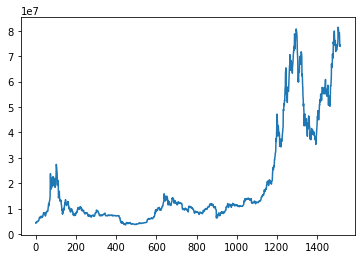

In [57]:
plt.plot(BTC['close'])
plt.show()

#그래프는 우리가 보는거에 좌우 반전이나 현 시점에서 그렇게 중요하지 않음

### 3) 모든 암호화폐에 대하여

In [58]:
for j in crypto :
  for i in n:
    j['MA{0}'.format(i)]= j['close'].rolling(window=i).mean().shift(-(i-1))

In [60]:
BTC.head()

,index,open,high,low,close,volume,value,MA7,MA30,MA90,MA180
0,2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,4.628571e+06,5.665900e+06,1.018777e+07,1.206843e+07
1,2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,4.729000e+06,5.743267e+06,1.035743e+07,1.209764e+07
2,2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,4.820857e+06,5.826267e+06,1.052967e+07,1.212628e+07
3,2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,4.854857e+06,5.894700e+06,1.072162e+07,1.215070e+07
4,2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,4.903429e+06,5.965667e+06,1.091478e+07,1.217328e+07


## III.표준편차(SD),Z밸류 작업

### 3) 모든 암호화폐에 대하여

In [61]:
for j in crypto:
  for i in n :
    j['MA{0}SD'.format(i)]= j['close'].rolling(window=i).std().shift(-(i-1))
  for i in n :
    j['MA{0}_z_value'.format(i)] = (j['close']-j['MA{0}'.format(i)])/(j['MA{0}SD'.format(i)])

In [63]:
BTC.head()

,index,open,high,low,close,volume,value,MA7,MA30,MA90,MA180,MA7SD,MA30SD,MA90SD,MA180SD,MA7_z_value,MA30_z_value,MA90_z_value,MA180_z_value
0,2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,4.628571e+06,5.665900e+06,1.018777e+07,1.206843e+07,249724.419539,898668.492060,5.599293e+06,5.582754e+06,-1.227639,-1.495435,-1.047591,-1.387564
1,2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,4.729000e+06,5.743267e+06,1.035743e+07,1.209764e+07,247232.009794,878667.405333,5.650671e+06,5.555686e+06,-1.650272,-1.618663,-1.068268,-1.399762
2,2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,4.820857e+06,5.826267e+06,1.052967e+07,1.212628e+07,180941.453304,857023.273870,5.700627e+06,5.528592e+06,-0.905581,-1.364335,-1.030179,-1.351028
3,2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,4.854857e+06,5.894700e+06,1.072162e+07,1.215070e+07,166830.681202,842276.969354,5.790809e+06,5.505076e+06,-1.611557,-1.553764,-1.059545,-1.374132
4,2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,4.903429e+06,5.965667e+06,1.091478e+07,1.217328e+07,117797.647321,817536.093618,5.873192e+06,5.482160e+06,-2.091965,-1.600745,-1.065481,-1.371044


## IV. bounds(통계기간) 작업


In [52]:
#n = 개인의 1회 투자 기간
#crypto = (암호화폐)의 종류
#bounds = 참조해야할 범위 <- 질문: 최근 몃달(혹은년) 범위의 통계를 보시겠습니까?
n = [7,30,90,180]
crypto = [ADA,BTC,BTC,DOGE,EOS,ETH,OMG,SNT,XRP]
crypto_name = ['ADA','BTC','BTC','DOGE','EOS','ETH','OMG','SNT','XRP']
bounds = [7,30,180,360]

### 3) 모든 bounds 에 관하여
* key,value 로 저장하기

In [53]:
DF = dict()
for l,k in zip(crypto_name,crypto):
  for j in n:
    for i in bounds:
       DF['{2};MA{1};bounds{0};'.format(i,j,l)] = np.sqrt(k['이동평균{0}일z밸류제곱'.format(j)][0:i].mean())

KeyError: ignored

In [ ]:
DF

{'AAPL;MA180;bounds180;': 1.3293886940189088,
 'AAPL;MA180;bounds30;': 1.0143585957869106,
 'AAPL;MA180;bounds360;': 1.5968780244919631,
 'AAPL;MA180;bounds720;': 1.5395839717650384,
 'AAPL;MA180;bounds7;': 1.305986909172706,
 'AAPL;MA30;bounds180;': 1.4169142757897328,
 'AAPL;MA30;bounds30;': 1.3145033802299453,
 'AAPL;MA30;bounds360;': 1.3891206119996986,
 'AAPL;MA30;bounds720;': 1.4423030173921283,
 'AAPL;MA30;bounds7;': 1.4875067168791805,
 'AAPL;MA7;bounds180;': 1.0648968163940704,
 'AAPL;MA7;bounds30;': 1.0100241025545762,
 'AAPL;MA7;bounds360;': 1.1009314872796157,
 'AAPL;MA7;bounds720;': 1.1112894541512026,
 'AAPL;MA7;bounds7;': 0.9576343635385198,
 'AAPL;MA90;bounds180;': 1.1687197929653488,
 'AAPL;MA90;bounds30;': 0.6261752174617847,
 'AAPL;MA90;bounds360;': 1.3619034815613607,
 'AAPL;MA90;bounds720;': 1.392185881064238,
 'AAPL;MA90;bounds7;': 1.0387223446585108,
 'BABA;MA180;bounds180;': 1.6102717441260095,
 'BABA;MA180;bounds30;': 1.5372783026627161,
 'BABA;MA180;bounds360;

### 검산!

In [51]:
DF_BTC = dict()
for j in n:
  for i in bounds:
      DF_BTC['WFC;MA{1};bounds{0};'.format(i,j)] = np.sqrt(BTC['이동평균{0}일z밸류제곱'.format(j)][0:i].mean())

KeyError: ignored

In [ ]:
DF_WFC

{'WFC;MA180;bounds180;': 1.6194769220283465,
 'WFC;MA180;bounds30;': 1.3031900777349221,
 'WFC;MA180;bounds360;': 1.4978341341111123,
 'WFC;MA180;bounds720;': 1.5739513121789699,
 'WFC;MA180;bounds7;': 1.7456341559658952,
 'WFC;MA30;bounds180;': 1.373679153434037,
 'WFC;MA30;bounds30;': 1.370965883812696,
 'WFC;MA30;bounds360;': 1.3351226069363786,
 'WFC;MA30;bounds720;': 1.3493811718198814,
 'WFC;MA30;bounds7;': 1.4959112108717554,
 'WFC;MA7;bounds180;': 1.1165743886674333,
 'WFC;MA7;bounds30;': 1.137144458121965,
 'WFC;MA7;bounds360;': 1.1358698008009676,
 'WFC;MA7;bounds720;': 1.1291182603942518,
 'WFC;MA7;bounds7;': 1.2797791467085966,
 'WFC;MA90;bounds180;': 1.3915045302351168,
 'WFC;MA90;bounds30;': 1.3931942570941422,
 'WFC;MA90;bounds360;': 1.4306127188329094,
 'WFC;MA90;bounds720;': 1.4583288471675826,
 'WFC;MA90;bounds7;': 1.8716589975033837}

## V. 지표로 분류 순번 지정

### bounds, MA,(감정분석) 별로 딕셔너리 생성
- DF 값들을 각각의 (bounds별로) 새로운 하나의 테이블로 구성시킨다.
- 순위에따라 가상의 점수를 붙인다.

### 1) 기본코드 만들기

In [ ]:
DF.get('WFC;MA180;bounds30;')


1.3031900777349221

In [ ]:
for i in DF.keys():
  if i == 'WFC;MA90;bounds360':
    print(i,DF.get(i))

In [ ]:
for i in DF.keys():
  if i.find('WFC;MA90;bounds360;') >= True:
    print(i,DF.get(i))

In [ ]:
# for i in DF.keys():
#   if i.find('bounds720') >= 0:
#     if i.find('MA7') >= 0 :

#      print(i)
#      a = i
#      b = DF.get(i)
#      data = [a,b]
#      DF_MA7_bounds720.append(data)
# df = pd.DataFrame(DF_MA7_bounds720)
# df


In [ ]:
DF_MA180_bounds7201 = []
for i in DF.keys():
  if i.find('bounds720;') >= 0:
    if i.find('MA180;') >= 0 :

     print(i)
     a = i.split(';')[0]
     b = i.split(';')[1]
     c = i.split(';')[2]
     d = DF.get(i)
     data = [a,b,c,d]
     DF_MA180_bounds7201.append(data)
df2 = pd.DataFrame(DF_MA180_bounds7201)
df2.columns = ['stocks','MA','bounds','z_value']
df2.info()
df2.to_csv('/content/drive/MyDrive/Colab Notebooks/datasets/test/MA_bounds_{0}.csv'.format(i), index =False)

AAPL;MA180;bounds720;
BABA;MA180;bounds720;
C;MA180;bounds720;
INTC;MA180;bounds720;
MSFT;MA180;bounds720;
UGL;MA180;bounds720;
WFC;MA180;bounds720;
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stocks   7 non-null      object 
 1   MA       7 non-null      object 
 2   bounds   7 non-null      object 
 3   z_value  7 non-null      float64
dtypes: float64(1), object(3)
memory usage: 352.0+ bytes


In [ ]:
df2

,stocks,MA,bounds,z_value
0,AAPL,MA180,bounds720,1.539584
1,BABA,MA180,bounds720,1.415728
2,C,MA180,bounds720,1.373813
3,INTC,MA180,bounds720,1.231758
4,MSFT,MA180,bounds720,1.721190
5,UGL,MA180,bounds720,1.466985
6,WFC,MA180,bounds720,1.573951


### 1) 2. 순위 지정하기

In [ ]:
df2['z_value_rank']=df2['z_value'].rank(method='max')

In [ ]:
df2

,stocks,MA,bounds,z_value,z_value_rank
0,AAPL,MA180,bounds720,1.539584,5.0
1,BABA,MA180,bounds720,1.415728,3.0
2,C,MA180,bounds720,1.373813,2.0
3,INTC,MA180,bounds720,1.231758,1.0
4,MSFT,MA180,bounds720,1.721190,7.0
5,UGL,MA180,bounds720,1.466985,4.0
6,WFC,MA180,bounds720,1.573951,6.0


### 2) 모든 MA,bounds 일반화

일단 리스트 자동으로 정의

In [ ]:
#현재까지 모든 경우의 수
for i in n :
  for j in bounds :
    print('DF_MA{0}_bounds{1}'.format(i,j))
    # print(type('DF_MA{0}_bounds{1}'.format(i,j)))


DF_MA7_bounds7
DF_MA7_bounds30
DF_MA7_bounds180
DF_MA7_bounds360
DF_MA7_bounds720
DF_MA30_bounds7
DF_MA30_bounds30
DF_MA30_bounds180
DF_MA30_bounds360
DF_MA30_bounds720
DF_MA90_bounds7
DF_MA90_bounds30
DF_MA90_bounds180
DF_MA90_bounds360
DF_MA90_bounds720
DF_MA180_bounds7
DF_MA180_bounds30
DF_MA180_bounds180
DF_MA180_bounds360
DF_MA180_bounds720


In [ ]:
for k in n:
  for j in bounds :

    DFX = []

    for i in DF.keys():
      if i.find('bounds{0};'.format(j)) >= 0:
        if i.find('MA{0};'.format(k)) >= 0 :

          a = i.split(';')[0]
          b = i.split(';')[1]
          c = i.split(';')[2]
          d = DF.get(i)
          data = [a,b,c,d]
          DFX.append(data)
          dfx = pd.DataFrame(DFX)
          dfx.columns = ['stocks','MA','bounds','z_value']
          dfx['z_value_rank']=dfx['z_value'].rank(method='max')
          dfx.to_csv('/content/drive/MyDrive/Colab Notebooks/datasets/test/MA{0}_bounds{1}_.csv'.format(k,j), index =False)

## ----------------여기까지 가공데이터 적재

## VI. 함수 정의

절대값함수 상하반전, 극점을 고객이 원하는 위치

### 1) 일반함수
- y = -abs(x-a)+b
- b는 주식(암호와폐의 수)
- a는 고객이 원하는 성향선택지(상중하 등 변화폭 원하는지)

In [ ]:
b = len(stocks)

In [ ]:
#성향선택지 - 일단 4분류
a0 = b*0
a1 = b*0.33
a2 = b*0.66
a3 = b*1

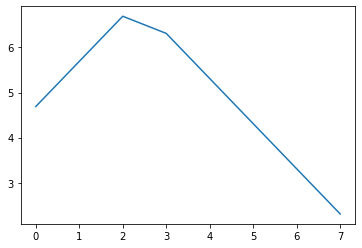

In [ ]:
x = [0,1,2,3,4,5,6,7]
y = []
for i in x:
  Y = -abs(i-a1) + b
  y.append(Y)
plt.plot(x,y)
plt.show()

### 2) 예제 데이터 일반함수에 적용

- (인풋이) 30일동안 수익내고 싶은 고객이 360일 통계를 보고 싶다.
- (인풋이) 가격폭이 중상의 주식(암호화폐)를 추천 받고싶다

In [ ]:
# input의 예
input_n = 30
input_bounds = 360
input_amplitude_level = a3

In [ ]:
input_amplitude_level

7

In [ ]:
#함수 정의
def y(x,a):
  Y = -abs(x-a) + len(stocks)
  return Y

In [ ]:
out_DF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/test/MA{0}_bounds{1}_.csv'.format(input_n,input_bounds))

In [ ]:
#여기서 z_value_rank 가 함수의 x 값 그리고 높은 y 값으로 고객한테 추천
out_DF

,stocks,MA,bounds,z_value,z_value_rank
0,AAPL,MA30,bounds360,1.389121,7.0
1,BABA,MA30,bounds360,1.364881,5.0
2,C,MA30,bounds360,1.329591,2.0
3,INTC,MA30,bounds360,1.346423,4.0
4,MSFT,MA30,bounds360,1.387447,6.0
5,UGL,MA30,bounds360,1.323537,1.0
6,WFC,MA30,bounds360,1.335123,3.0


In [ ]:
for i in out_DF['z_value_rank']:
  print(y(i,input_amplitude_level))

7.0
5.0
2.0
4.0
6.0
1.0
3.0


### 3) 최종 점수판 정의


In [ ]:
coustomer_finalscore = {}

In [ ]:
for j,i in zip(out_DF['stocks'],out_DF['z_value_rank']):
  print(j,y(i,input_amplitude_level))
  coustomer_finalscore[j] = y(i,input_amplitude_level)

AAPL 7.0
BABA 5.0
C 2.0
INTC 4.0
MSFT 6.0
UGL 1.0
WFC 3.0


In [ ]:
coustomer_finalscore

{'AAPL': 7.0,
 'BABA': 5.0,
 'C': 2.0,
 'INTC': 4.0,
 'MSFT': 6.0,
 'UGL': 1.0,
 'WFC': 3.0}

## VII. 최종 점수판 기준 output하기

In [ ]:
out_put = max(coustomer_finalscore,key=coustomer_finalscore.get)
print(out_put)

AAPL


### ---초본 완성---